In [329]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from datetime import datetime
import re
import ast

# from pandas_profiling import ProfileReport

import my_functions
import importlib
importlib.reload(my_functions)

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats


In [330]:
RANDOM_SEED = 123

In [331]:
input_folder = 'input//'
print(os.listdir("input"))


['main_task.csv', 'csv_city.csv', 'kaggle_task.csv', 'sample_submission.csv']


# DATA
### main_task.csv - оригинальные данные
### kaggle_task.csv - данные добавленные для соревнование на площаке kaggle для тестирования модели
### sample_submission.csv - результаты для проверки модели

In [332]:
data = pd.read_csv(input_folder + 'main_task.csv')
data_kaggle = pd.read_csv(input_folder + 'kaggle_task.csv')
sample_submission = pd.read_csv(input_folder + '/sample_submission.csv')


In [333]:
# дря корректной обработки признаков объединяем трейн и тест в один датасет
data['sample'] = 1 # помечаем где у нас трейн
data_kaggle['sample'] = 0 # помечаем где у нас тест
data_kaggle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = data_kaggle.append(data, sort=False).reset_index(drop=True) # объединяем

## Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:
* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvosor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [334]:
data.columns = data.columns.str.lower()
data.columns = [name.replace(' ', '_') for name in data.columns]
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


# Обработка NaN

In [335]:
data['cuisine_style_isNAN'] = pd.isna(data.cuisine_style).astype('uint8')
data['cuisine_style'] = data['cuisine_style'].fillna('[\'not_specified\']')

data['Number_of_Reviews_isNAN'] = pd.isna(data.number_of_reviews).astype('uint8')
data['number_of_reviews'] = data.groupby(by='city').number_of_reviews.apply(lambda x: x.fillna(round(x.mean())))

data['price_range_isNAN'] = pd.isna(data.price_range).astype('uint8')
data['price_range'].fillna(data.price_range.mode()[0], inplace=True)

data.reviews.fillna("[[], []]",inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   restaurant_id            50000 non-null  object 
 1   city                     50000 non-null  object 
 2   cuisine_style            50000 non-null  object 
 3   ranking                  50000 non-null  float64
 4   price_range              50000 non-null  object 
 5   number_of_reviews        50000 non-null  float64
 6   reviews                  50000 non-null  object 
 7   url_ta                   50000 non-null  object 
 8   id_ta                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  rating                   50000 non-null  float64
 11  cuisine_style_isNAN      50000 non-null  uint8  
 12  Number_of_Reviews_isNAN  50000 non-null  uint8  
 13  price_range_isNAN        50000 non-null  uint8  
dtypes: float64(3), int64(1

# Предобработка

In [336]:
data.drop(['restaurant_id', 'url_ta', 'id_ta'], inplace=True,  axis = 1, errors='ignore')
data['cuisine_style'] = data['cuisine_style'].apply(ast.literal_eval)
data['reviews'] = data['reviews'].apply(lambda x: re.sub((r'\bnan\b'), '\'empty_voice\'', x))
data['reviews'] = data['reviews'].apply(ast.literal_eval)

# Обогащаем новыми признаками 

In [337]:
# 4EKAEM
# data['nor_above2000'] = data.number_of_reviews.apply(lambda x: 1 if x > 2000 else 0 )
# data['nor_above4000'] = data.number_of_reviews.apply(lambda x: 1 if x > 4000 else 0 )
# data['nor_above8000'] = data.number_of_reviews.apply(lambda x: 1 if x > 8000 else 0 )
# data['number_of_reviews'] = data.number_of_reviews.apply(lambda x: 2000 if x > 2000 else x)

data['reviews_text'] =  data['reviews'].apply(lambda x: x[0])
data['reviews_dates'] = data['reviews'].apply(lambda x: [datetime.strptime(date, '%m/%d/%Y').date() for date in x[1]])
data['empty_reviews'] = data.reviews_text.apply(lambda x: 1 if len(x)==0 else 0)

data['price_range_int'] = data.price_range.apply(lambda x: 1 if x == '$' else 
                                                              (2 if x == '$$ - $$$' else 3))
data['review_text_tone_coef'] = data['reviews_text'].apply(lambda x: my_functions.review_text_tone(x))


set_dates = set()
data['dif_days'] = data.reviews_dates.apply(lambda x: (x[0] - x[-1]) if len(x) > 0 else pd.Timedelta('0 days') ).dt.days

last_date = set()
data.reviews_dates.apply(lambda x: last_date.update(x))
data['diff_last_date'] = data.reviews_dates.apply(my_functions.diff_today)


cuisine_style_set = set()
data.cuisine_style.apply(lambda x: cuisine_style_set.update(x))
cuisine_style_list = list(cuisine_style_set)
for cuisine in cuisine_style_list:
    data[cuisine] = data.cuisine_style.apply(lambda x: 1 if cuisine in x else 0)

data['city_orig'] = data['city'] 
data = pd.get_dummies(data, columns=['city_orig'], dummy_na=True, drop_first=False)

In [338]:
city_dict = data.groupby(by='city').city.size()
# data['quan_in_city'] = data.city.apply(lambda x: len(data[data.city == x]))
# data['ranking_for_city'] =  data['ranking'] / data.city.apply(lambda x: city_dict[x])

data['ranking_by_reviews'] = data['number_of_reviews'] * data['ranking']


In [339]:

city_data = pd.read_csv('input//csv_city.csv', index_col='name')
city_data.drop('country', axis=1, inplace=True)
city_data = city_data.to_dict()['pop']
data['city_pop'] = data.city.apply(lambda x: int(city_data[x]))

data['ranking_by_pop'] = data['ranking'] / data['city_pop']



In [340]:
data['ranking_by_city'] = data.groupby(by='city').ranking.transform(lambda x: (len(x) / x) )
data['number_of_reviews_dif_by_city'] = data.groupby('city').number_of_reviews.transform(lambda x: x / (max(x) - min(x))) 

## Нормируем признаки

In [341]:
# data['ranking_norm_by_city'] = data.groupby('city').ranking.transform(lambda x: (x - x.mean()) / x.std())
# data['number_of_reviews_norm_by_city'] = data.groupby('city').number_of_reviews.transform(lambda x: (x - x.mean()) / x.std()) 
# data['number_of_reviews_norm'] = data.number_of_reviews.apply(lambda x: (x - data.number_of_reviews.mean()) / 
# data.number_of_reviews.std())

# data['ranking_by_reviews_norm'] = data['ranking_by_reviews'].apply(lambda x: (x - data.ranking_by_reviews.mean()) / data.ranking_by_reviews.std())

# ranking_by_pop_mean = data.ranking_by_pop.mean()
# ranking_by_pop_std = data.ranking_by_pop.std()
# data['ranking_by_pop_norm'] =  data.ranking_by_pop.apply(lambda x: (x - ranking_by_pop_mean) / ranking_by_pop_std)

In [342]:
# data['quan_in_city'] = data.city.apply(lambda x: len(data[data.city == x]))

In [343]:
# data['review_text_tone_coef'] = data['reviews_text'].apply(lambda x: my_functions.review_text_tone(x))

# data['review_text_tone_coef'].value_counts()
# data['good_reviews'] = data.review_text_tone_coef.apply(lambda x: 1 if x > 1 else 0)
# data['bad_reviews'] = data.review_text_tone_coef.apply(lambda x: 1 if x < -1 else 0)


# data['quan_in_city'] = data.city.apply(lambda x: data[data.city == x].size)


# datetime.today().date()

#data.iloc[:2].reviews_dates.apply(max)
# data[data.city == 'London'].ranking_mean_by_city
# data['review_text_tone_coef'].value_counts()
# data['ranking_by_reviews'] = data.ranking_by_reviews.apply(lambda x: (x - data.ranking_by_reviews.mean()) / data.ranking_by_reviews.std())
# data['ranking_by_reviews']
# data['ranking_by_reviews'].value_counts(bins=20)

# EDA

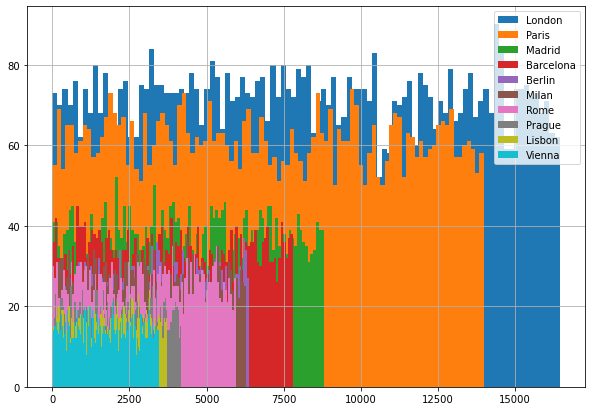

In [344]:
plt.rcParams['figure.figsize'] = (10,7)

top10_city = data.city.value_counts()[0:10].index
for city in top10_city:
    data[(data.city == city)].ranking.hist(bins=100, label=city)
    plt.legend()

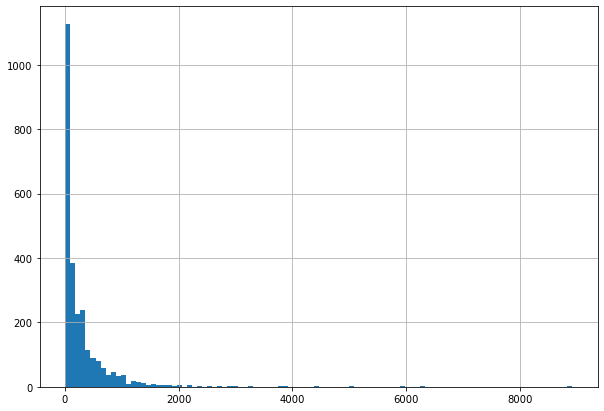

In [345]:
data[data.city=='Rome'].number_of_reviews.hist(bins=100)

In [346]:
data.groupby('price_range_int').agg({'ranking': 'mean', 'rating': 'mean', 'number_of_reviews':'mean', 'city': lambda x: stats.mode(x) })

,ranking,rating,number_of_reviews,city
price_range_int,,,,
1,3537.962257,3.287615,93.543245,"([London], [1269])"
2,3764.147072,3.169200,118.829563,"([London], [5648])"
3,1958.245230,3.357744,368.691919,"([Paris], [283])"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ac4147d90>,
      dtype=object)

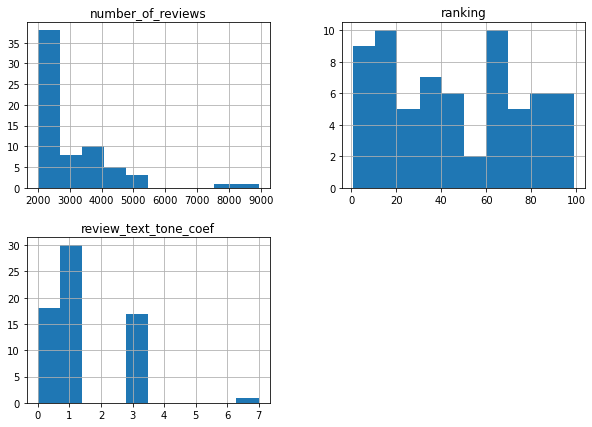

In [347]:
data[((0 < data.ranking)&(data.ranking < 100 )) & (data.number_of_reviews>2000)][[ 'ranking',
                                               'reviews_text', 
                                               'number_of_reviews',  
                                               'review_text_tone_coef']].hist()

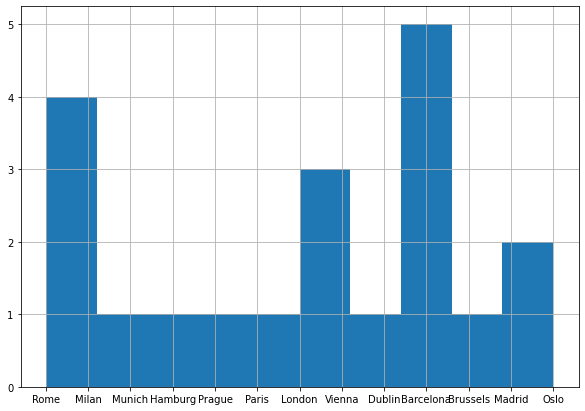

In [348]:
data.city[10:30].hist()

## CORRELATION

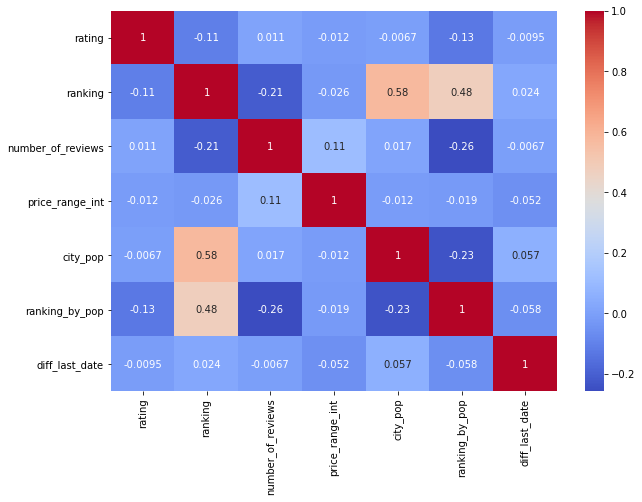

In [349]:


data.price_range.value_counts(dropna=False)

# data.groupby(by='city').agg({'price_range_int':'mean', 'city':'size'}).sort_values(by='price_range_int')
# data['price_range'] = data['price_range'].astype(str)
# data.groupby(by='price_range').agg({'city':lambda x: stats.mode(x) , 'ranking': 'mean', 'rating' : 'mean', 'number_of_reviews':'mean', 'dif_days':'mean'})

correlation = data[['rating','ranking',  'number_of_reviews', 
                    #'ranking_by_reviews_norm',
                    # 'ranking_for_city',
                    # 'ranking_norm_by_city',
                    #'number_of_reviews_dif_by_city',
                    'price_range_int',
                    'city_pop',
                    'ranking_by_pop',
                    #'ranking_by_pop_norm',
                    #'number_of_reviews_norm_by_city',
                    'diff_last_date'
                    ]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [350]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# Model

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


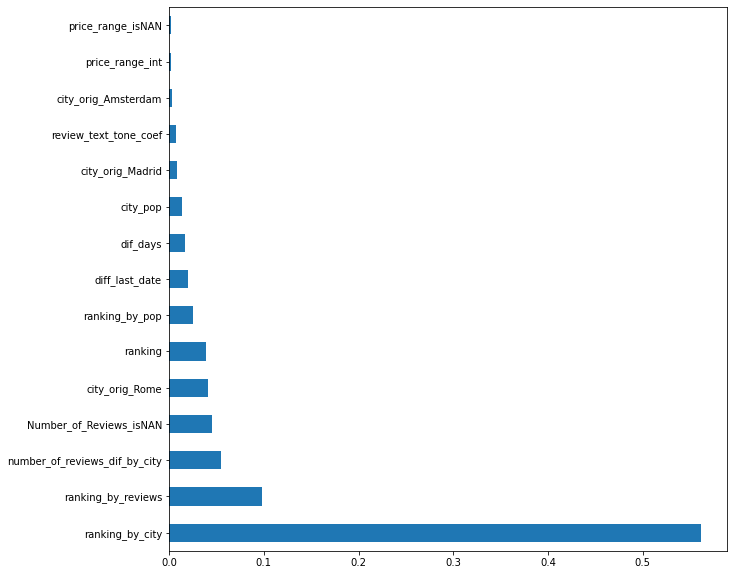

In [355]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.linear_model import LinearRegression

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
object_columns = [s for s in train_data.columns if train_data[s].dtypes == 'object']
train_data.drop(object_columns, axis = 1, inplace=True)

X = train_data.drop(['rating',                       
                     #'ranking',
                     'ranking_for_city',
                     #'ranking_norm_by_city',
                     'number_of_reviews',
                     'ranking_by_reviews_norm',
                     #'ranking_by_reviews'
                     #'ranking_by_pop',
                     #'ranking_by_pop_norm'
                     ], 
               axis = 1, errors='ignore')


y = train_data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [354]:
vectorized_round = np.vectorize(my_functions.round_rating)
y_pred = vectorized_round(y_pred)
y_pred

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

In [353]:
y_pred = y_pred_round
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))


ValueError: Found input variables with inconsistent numbers of samples: [8000, 0]

MAE: 0.204828125  
MAE: 0.20562   
MAE: 0.20900624999999998  
MAE: 0.20914499999999997  
MAE: 0.2097025   
MAE: 0.209354375  
MAE: 0.20936249999999998  
MAE: 0.20936249999999998   
MAE: 0.20969625000000003  
MAE: 0.210050625  
MAE: 0.21450125  
0.21451624999999996  
MAE: 0.21875124999999998  
MAE: 0.2084305  
MAE: 0.210808  
0.2131725  
MAE: 0.2148355  
MAE: 0.21277599999999997  
MAE: 0.2086605   
MAE: 0.34141057440476186